In [1]:
%matplotlib tk
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay, delaunay_plot_2d
import cv2
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import os
import matplotlib.image as mpimg

In [2]:
im1 = np.array(Image.open("assets/test/face.jpg"))
im2 = np.array(Image.open("assets/test/tiger.jpg").resize((im1.shape[1], im1.shape[0])))

In [3]:
def get_keypoints(im1, im2):
    """
    Allows user to input key points

    Returns:
        n: number of keypoints
        keypoints: np.ndarray of shape (n,4) in format of x1,y1,x2,y2 
    """
    n = 0
    keypoints = []
    
    h1,w1,_ = im1.shape
    h2,w2,_ = im2.shape
    im_combine = np.hstack((im1, im2))

    plt.figure()
    plt.imshow(im_combine)
    plt.show()

    while True:
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        
        if not clicked or len(clicked) < 2:
            break

        keypoints.append([clicked[0][0], clicked[0][1], clicked[1][0]-w1, clicked[1][1]]) # -w1 to offset im1

        c = np.random.rand(3,)
        plt.scatter(clicked[0][0], clicked[0][1], color=c)
        plt.scatter(clicked[1][0], clicked[1][1], color=c)
        n += 1
        
    keypoints = keypoints + [[0,0,0,0], [w1,0,w2,0], [0,h1,0,h2], [w1,h1,w2,h2]] # add 4 corners
    
    plt.close()

    return n, np.array(keypoints, dtype=int)

In [4]:
def display_img_kp(im, kps):
    
    """
    Display image along with keypoints
    """
    
    plt.imshow(im)
    for kp in kps:
        plt.scatter(kp[0], kp[1], color='b')
    plt.show()
    

In [5]:
# reference: https://www.geeksforgeeks.org/check-whether-a-given-point-lies-inside-a-triangle-or-not/

def generate_triangle_mask(tri, P):
    
    A,B,C = tri[0,:], tri[1,:], tri[2,:]
    
    denominator = ((B[1] - C[1]) * (A[0] - C[0]) +
                   (C[0] - B[0]) * (A[1] - C[1]))
    a = ((B[1] - C[1]) * (P[:,0] - C[0]) +
         (C[0] - B[0]) * (P[:,1] - C[1])) / denominator
    b = ((C[1] - A[1]) * (P[:,0] - C[0]) +
         (A[0] - C[0]) * (P[:,1] - C[1])) / denominator
    c = 1 - a - b

    return np.logical_and(np.logical_and(a>=0,b>=0), c>=0)

In [6]:
def solve_tri_affine(triangles, kp1, kp2):
    
    """
    Solver for affine transformation from kp1 -> kp2 for each triangle in triangles
    """
    
    affine_Ts = np.zeros((triangles.shape[0], 2, 3))
    
    for i in range(triangles.shape[0]):
        
        tri_idx = triangles[i]
        
        kp1_tri = kp1[tri_idx]
        kp2_tri = kp2[tri_idx]
        
        A = []
        b = []
        
        for j in range(3):
        
            x1,y1,x2,y2 = kp1_tri[j,0], kp1_tri[j, 1], kp2_tri[j,0], kp2_tri[j,1]
            A.append([x1,y1,1,0,0,0])
            A.append([0,0,0,x1,y1,1])
            b.append(x2)
            b.append(y2)
            
        A=np.array(A)
        b=np.array(b)
        
        affine_T = np.linalg.solve(A, b)
        
        affine_Ts[i] = affine_T.reshape((2,3))
    
    return affine_Ts

In [7]:
# Left click on image for point correspondences, middle click to end
n, keypoints = get_keypoints(im1, im2)
kp1 = keypoints[:, :2]
kp2 = keypoints[:, 2:]

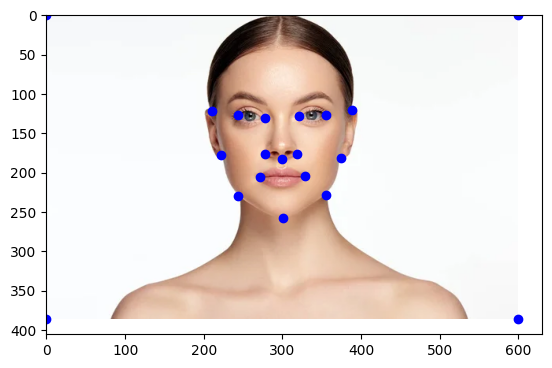

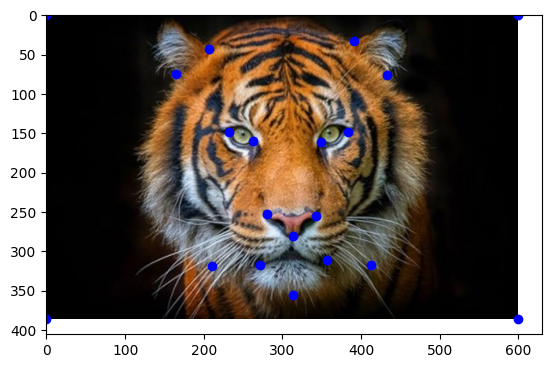

In [8]:
%matplotlib inline
display_img_kp(im1, kp1)
display_img_kp(im2, kp2)

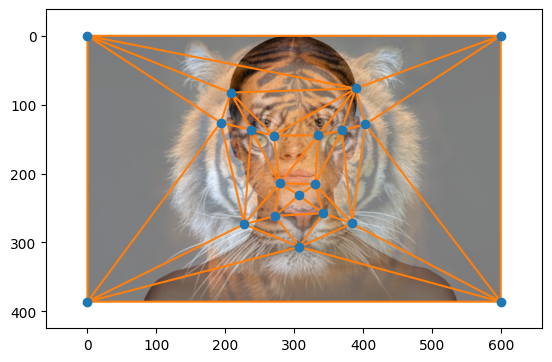

In [9]:
avg_points = 0.5 * keypoints[:, :2] + 0.5 * keypoints[:, 2:]
tri = Delaunay(avg_points)
delaunay_plot_2d(tri)
plt.imshow((0.5*im1+0.5*im2).astype(np.uint8))
plt.gca().invert_yaxis() # why is axis flipped???
plt.show()

In [10]:
triangles = tri.simplices # in the form of indexes of keypoints

In [11]:
affine_Ts = solve_tri_affine(triangles, kp1, kp2)

In [12]:
res = []

for t in np.arange(0.0, 1.0, 0.02):
    
    h,w,_ = im1.shape
    
    frame_res = np.zeros(im1.shape)
    
    kp_inter = t * kp1 + (1-t) * kp2
    affine_Ts_1 = solve_tri_affine(triangles, kp1, kp_inter)
    affine_Ts_2 = solve_tri_affine(triangles, kp2, kp_inter)
    
    res_im1 = np.zeros((im1.shape), dtype=np.uint8)
    res_im2 = np.zeros((im2.shape), dtype=np.uint8)
    
    for i in range(affine_Ts_1.shape[0]):
        affine_T_1 = affine_Ts_1[i]
        affine_T_2 = affine_Ts_2[i]
        tri_1 = kp1[triangles[i]]
        tri_2 = kp2[triangles[i]]
        tri_inter = kp_inter[triangles[i]]
        
        x = np.arange(w)
        y = np.arange(h)
        xv, yv = np.meshgrid(x, y)
        P = np.stack((xv,yv), axis=-1).reshape(-1,2) # gets a (hxw,2) numpy array of all coordinates of image
        
        mask = generate_triangle_mask(tri_inter, P).reshape((h,w)) # gets binary triangle mask for image1
        res_im1[mask] = cv2.warpAffine(im1, affine_T_1, (w, h), cv2.WARP_INVERSE_MAP)[mask]
        res_im2[mask] = cv2.warpAffine(im2, affine_T_2, (w, h), cv2.WARP_INVERSE_MAP)[mask]
    res_im = (res_im1 * t + res_im2 * (1-t)).astype(np.uint8)
    res.append(res_im)
    print(f"Done with {t}", end="\r", flush=True)

In [13]:
output_video_path = 'assets/output/output_video.avi'

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can choose another codec based on your needs
video_writer = cv2.VideoWriter(output_video_path, fourcc, 20.0,  (im1.shape[1], im1.shape[0]))

# Iterate through each frame and write it to the video
for frame in res:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame)
video_writer.release()